# Data analysis using the ARMA model

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas
import seaborn as sb
from scipy import optimize
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.api import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

plt.rcParams["figure.figsize"] = (10,6)

In [2]:
df = pandas.read_csv('london_weather.csv')

In [3]:
df.columns.values.tolist()

['date',
 'cloud_cover',
 'sunshine',
 'global_radiation',
 'max_temp',
 'mean_temp',
 'min_temp',
 'precipitation',
 'pressure',
 'snow_depth']

In [4]:
df['date']

0        19790101
1        19790102
2        19790103
3        19790104
4        19790105
           ...   
15336    20201227
15337    20201228
15338    20201229
15339    20201230
15340    20201231
Name: date, Length: 15341, dtype: int64

In [5]:
X = df['mean_temp']
X = np.array([i for i in X])
t = df['date']
t = np.array([np.floor(i*10**(-4)) for i in t])
X_test_raw = X[(t>2000) & (t<=2001)]
X = X[(t<=2000) & (t>=1998)]

In [6]:
t = np.arange(1, len(X)+1)

Scatter plot

In [7]:
t_test = np.arange(t[-1]+1, t[-1]+1+len(X_test_raw))

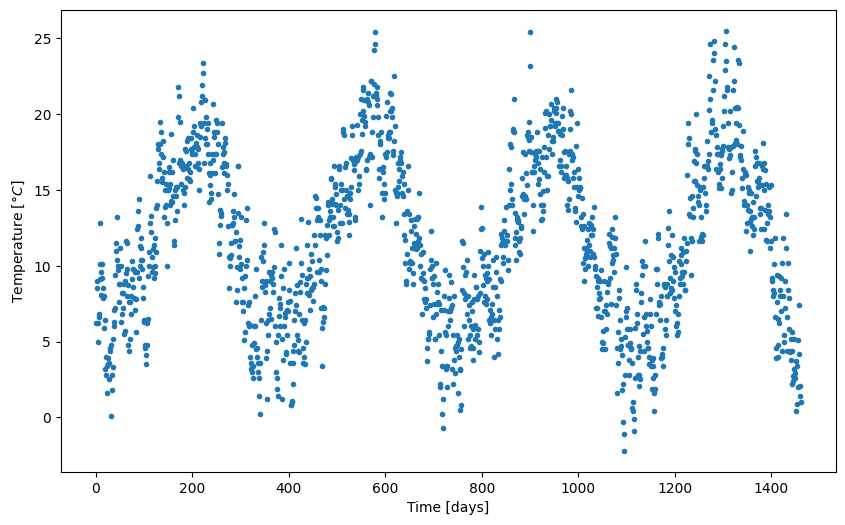

In [8]:
plt.plot(t, X, '.', color='C0')
plt.plot(t_test, X_test_raw, '.', color='C0')
plt.xlabel('Time [days]')
plt.ylabel('Temperature [$\degree C$]')
plt.show()

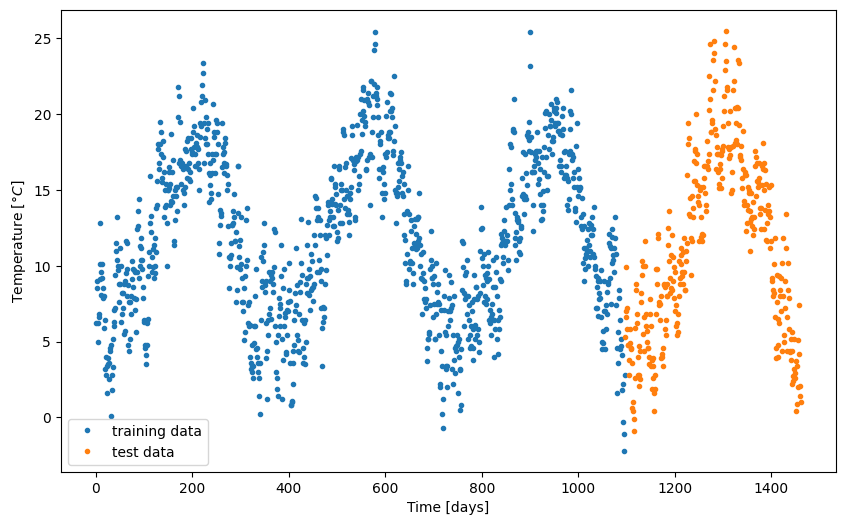

In [9]:
plt.plot(t, X, '.', color='C0', label='training data')
plt.plot(t_test, X_test_raw, '.', color='C1', label='test data')
plt.legend()
plt.xlabel('Time [days]')
plt.ylabel('Temperature [$\degree C$]')
plt.show()

### ACF and PACF for raw data

In [10]:
def sampleACVF(h, x):
    x_mean = np.mean(x)
    n = len(x)
    return np.sum((x[:n-h]-x_mean)*(x[h:]-x_mean))/n

def sampleACF(h, x):
    return sampleACVF(h, x) / sampleACVF(0, x)

In [11]:
def samplePACF(data, h):
    if h == 0:
        return 1
    gamma = np.array([sampleACVF(h_, data) for h_ in range(1, h+1)])
    G = np.array([[sampleACVF(np.abs(i-j), data) for j in range(1, h+1)] for i in range(1, h+1)])
    phi = np.dot(np.linalg.inv(G), gamma)
    return phi[-1]

In [12]:
h = 50

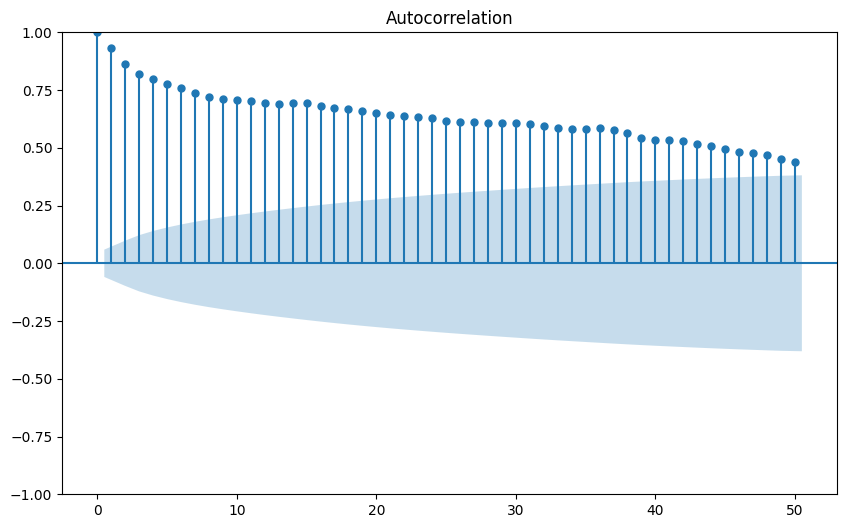

In [13]:
plot_acf(X, lags=h)
plt.show()

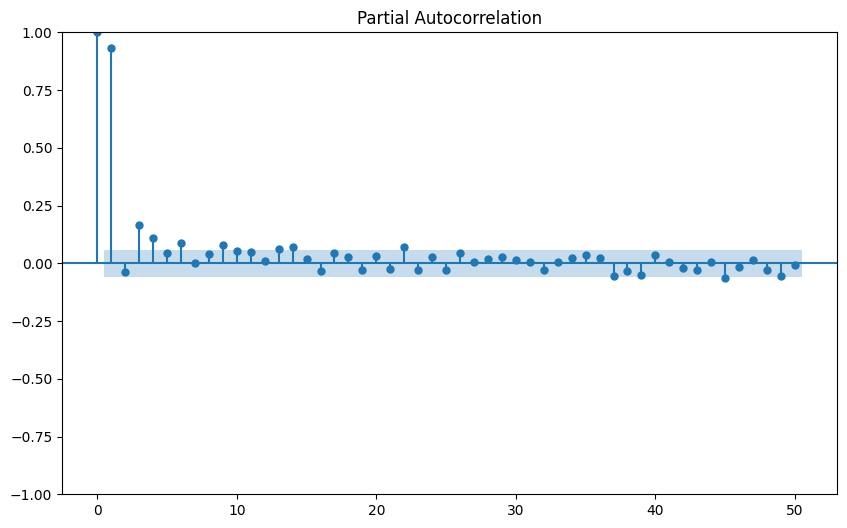

In [14]:
plot_pacf(X, lags=h)
plt.show()

### Decomposition

ADF test

In [15]:
adfuller(X)

(-2.2127337228069246,
 0.20165635393660225,
 13,
 1082,
 {'1%': -3.4364081161854747,
  '5%': -2.8642149051061954,
  '10%': -2.5681942108302214},
 4347.67935205681)

Decomposition

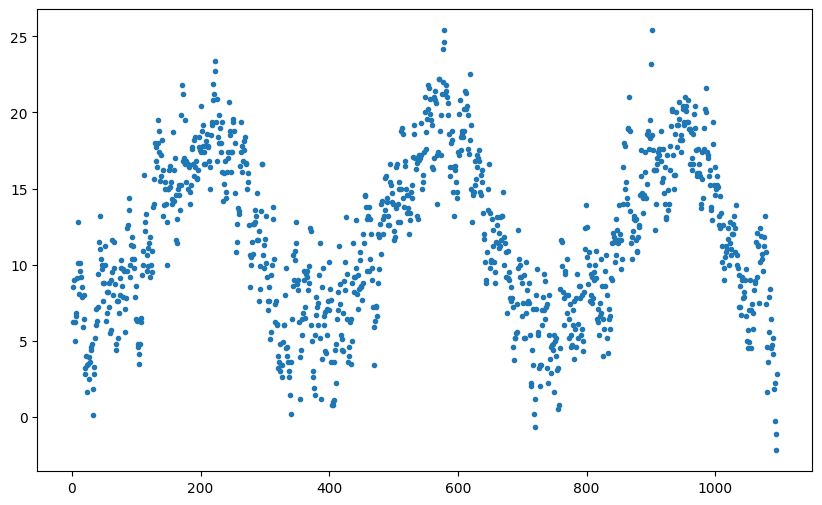

In [16]:
plt.plot(t, X, '.')
plt.show()

In [17]:
def b1_estimator(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    return sum((x-x_mean)*(y-y_mean))/sum((x-x_mean)**2)

def b0_estimator(x, y):
    return np.mean(y) - b1_estimator(x, y) * np.mean(x)

In [18]:
def m(t, a1, a2):
    return a1*t+a2

def s(t, b1, b2, b3):
    return b1*np.cos(b2*t+b3)

In [19]:
b0 = b0_estimator(t, X)
b1 = b1_estimator(t, X)
X_linear = m(t, b1, b0)
b1, b0

(0.0008590654152451653, 11.261284371562844)

In [20]:
X2 = X - X_linear

In [21]:
n = 2000

In [22]:
okres = 2000/5.5
b1_, b2_, b3_ = optimize.curve_fit(s, t, X2, [max(X2), 2*np.pi/okres, 26])[0]
X_cos = s(t, b1_, b2_, b3_)
b1_, b2_, b3_

(-6.338975478230817, 0.017162744798324067, 24.80864114563841)

In [23]:
X3 = X2 - X_cos

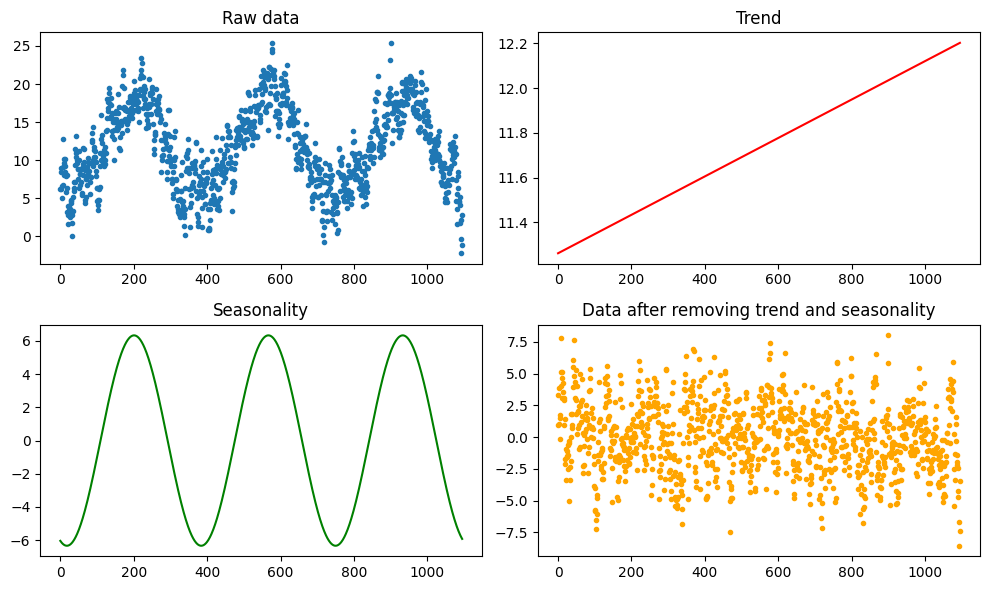

In [24]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(X, '.', label='Original')
plt.title('Raw data')

plt.subplot(2, 2, 2)
plt.plot(X_linear, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(X_cos, label='Seasonal', color='green')
plt.title('Seasonality')

plt.subplot(2, 2, 4)
plt.plot(X3, '.', label='Residual', color='orange')
plt.title('Data after removing trend and seasonality')

plt.tight_layout()
plt.show()

Tests

In [25]:
adfuller(X)

(-2.2127337228069246,
 0.20165635393660225,
 13,
 1082,
 {'1%': -3.4364081161854747,
  '5%': -2.8642149051061954,
  '10%': -2.5681942108302214},
 4347.67935205681)

In [26]:
adfuller(X2)

(-2.168349463942515,
 0.2179326093752721,
 13,
 1082,
 {'1%': -3.4364081161854747,
  '5%': -2.8642149051061954,
  '10%': -2.5681942108302214},
 4347.980527431851)

In [27]:
adfuller(X3)

(-11.411012832841905,
 7.250512593325061e-21,
 2,
 1093,
 {'1%': -3.4363470029475525,
  '5%': -2.864187948086107,
  '10%': -2.568179853605536},
 4277.530755197224)

ACF and PACF plots

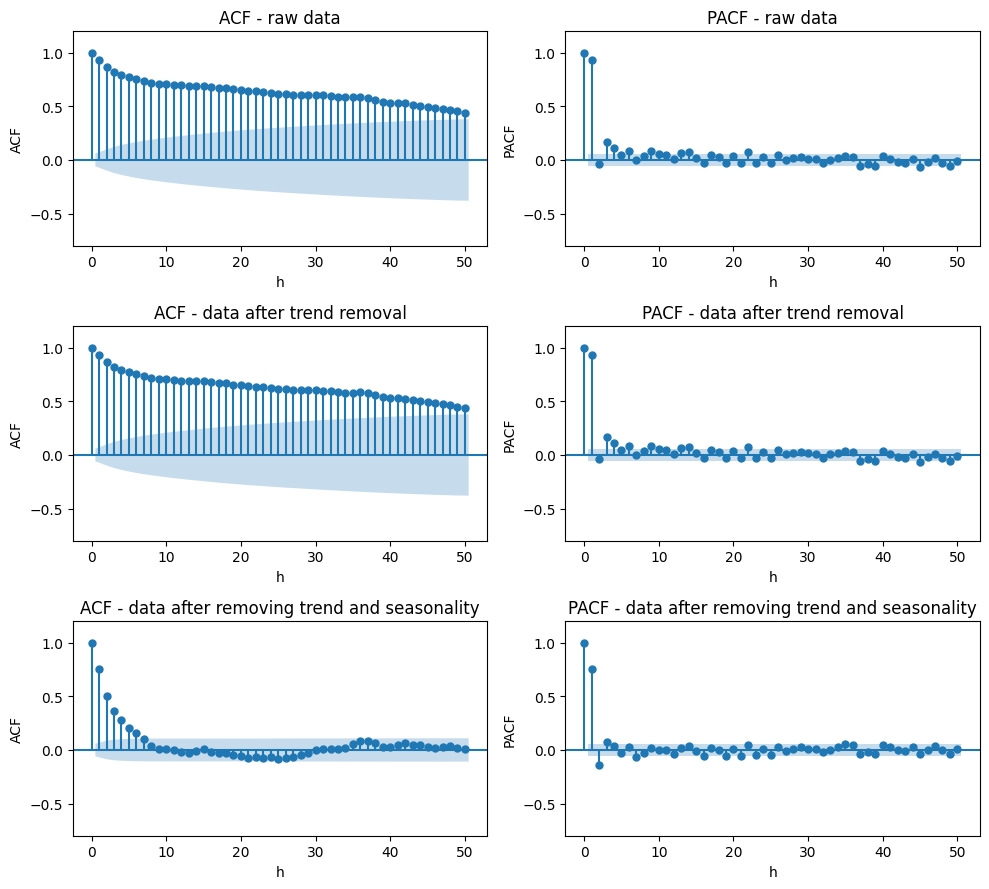

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(10, 9))

plot_acf(X, lags=50, ax=axes[0, 0])
axes[0, 0].set_xlabel('h')
axes[0, 0].set_ylabel('ACF')
axes[0, 0].set_title('ACF - raw data')
axes[0, 0].set_ylim(-0.8, 1.2)

plot_pacf(X, lags=50, ax=axes[0, 1])
axes[0, 1].set_xlabel('h')
axes[0, 1].set_ylabel('PACF')
axes[0, 1].set_title('PACF - raw data')
axes[0, 1].set_ylim(-0.8, 1.2)

plot_acf(X2, lags=50, ax=axes[1, 0])
axes[1, 0].set_xlabel('h')
axes[1, 0].set_ylabel('ACF')
axes[1, 0].set_title('ACF - data after trend removal')
axes[1, 0].set_ylim(-0.8, 1.2)

plot_pacf(X2, lags=50, ax=axes[1, 1])
axes[1, 1].set_xlabel('h')
axes[1, 1].set_ylabel('PACF')
axes[1, 1].set_title('PACF - data after trend removal')
axes[1, 1].set_ylim(-0.8, 1.2)

plot_acf(X3, lags=50, ax=axes[2, 0])
axes[2, 0].set_xlabel('h')
axes[2, 0].set_ylabel('ACF')
axes[2, 0].set_title('ACF - data after removing trend and seasonality')
axes[2, 0].set_ylim(-0.8, 1.2)

plot_pacf(X3, lags=50, ax=axes[2, 1])
axes[2, 1].set_xlabel('h')
axes[2, 1].set_ylabel('PACF')
axes[2, 1].set_title('PACF - data after removing trend and seasonality')
axes[2, 1].set_ylim(-0.8, 1.2)

plt.tight_layout()
plt.show()

In [29]:
t_test = np.arange(t[-1]+1, t[-1]+1+len(X_test_raw))
X_test = X_test_raw - m(t_test, b1, b0) - s(t_test, b1_, b2_, b3_)

## 3. Modeling data using the ARMA model

In [69]:
p_seq = np.arange(0, 4)
q_seq = np.arange(0, 7)

aic = 10**10
bic = 10**10
hqic = 10**10
p_aic = 0; q_aic = 0
p_bic = 0; q_bic = 0
p_hqic = 0; q_hqic = 0
for p in p_seq:
    for q in q_seq:
        if not (p == 0 and q ==0):
            arma_model = ARIMA(X3, order=(p, 0, q))
            arma_model_fit = arma_model.fit(method='statespace', method_kwargs={'maxiter':300})
            if arma_model_fit.aic < aic:
                p_aic = p; q_aic = q
            if arma_model_fit.bic < bic:
                p_bic = p; q_bic = q
            if arma_model_fit.hqic < hqic:
                p_hqic = p; q_hqic = q

In [70]:
p_aic, q_aic

(3, 6)

In [71]:
p_bic, q_bic

(3, 6)

In [72]:
p_hqic, q_hqic

(3, 6)

#### Parameter estimation

In [73]:
p = p_aic; q = q_aic
arma_model = ARIMA(X3, order=(p, 0, q))
arma_model_fit = arma_model.fit(method='statespace', method_kwargs={'maxiter':300})

In [74]:
arma_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1096
Model:                 ARIMA(3, 0, 6)   Log Likelihood               -2172.387
Date:                Thu, 21 Mar 2024   AIC                           4366.775
Time:                        10:59:15   BIC                           4421.768
Sample:                             0   HQIC                          4387.583
                               - 1096                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0181      0.211     -0.086      0.931      -0.431       0.395
ar.L1          0.9191      0.075     12.323      0.000       0.773       1.065
ar.L2         -1.0613      0.043    -24.611      0.000      -1.146      -0.977
ar.L3          0.6620      0.074      8.914      0.000       0.516       0.808
ma.L1         -0.0548      0.079     -0.695      0.487      -0.210       0.100
ma.L2          0.8329      0.061     13.761      0.000       0.714       0.951
ma.L3          0.1006      0.104      0.963      0.336      -0.104       0.305
ma.L4         -0.0073      0.084     -0.088      0.930      -0.171       0.156
ma.L5         -0.0666      0.048     -1.385      0.166      -0.161       0.028
ma.L6          0.0839      0.039      2.144      0.032       0.007       0.161
sigma2         3.0805      0.143     21.567      0.000       2.801       3.360
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.86
Prob(Q):                              0.97   Prob(JB):                         0.15
Heteroskedasticity (H):               0.97   Skew:                            -0.07
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
phi = arma_model_fit.arparams
theta = arma_model_fit.maparams
sigma2 = arma_model_fit.params[-1]

### Assessment of model fit

In [76]:
def samplePACF(data, h):
    if h == 0:
        return 1
    gamma = np.array([sampleACVF(h_, data) for h_ in range(1, h+1)])
    G = np.array([[sampleACVF(np.abs(i-j), data) for j in range(1, h+1)] for i in range(1, h+1)])
    phi = np.dot(np.linalg.inv(G), gamma)
    return phi[-1]

In [77]:
def ACF_intervals(h, phi, theta, sigma2, n, N=100):
    traj = np.array([arma_generate_sample(phi, theta, n, np.sqrt(sigma2)) for i in range(N)])
    autocor = np.array([[sampleACF(h_, traj[i]) for i in range(N)] for h_ in h])
    quantile95 = np.array([np.quantile(autocor[h_, :], 0.95) for h_ in h])
    quantile05 = np.array([np.quantile(autocor[h_, :], 0.05) for h_ in h])
    return quantile05, quantile95#, autocor[:,0]

In [78]:
def PACF_intervals(h, phi, theta, sigma2, n, N=100):
    traj = np.array([arma_generate_sample(phi, theta, n, np.sqrt(sigma2)) for i in range(N)])
    PACF = np.array([[samplePACF(traj[i], h_) for i in range(N)] for h_ in h])
    quantile95 = np.array([np.quantile(PACF[h_, :], 0.95) for h_ in h])
    quantile05 = np.array([np.quantile(PACF[h_, :], 0.05) for h_ in h])
    return quantile05, quantile95

In [79]:
n = len(X3)
h = np.arange(0, 30)

In [80]:
phi_to_intervals = np.array([1] + list(-phi) + [0, 0, 0])
theta_to_intervals = np.array([1] + list(theta))
len(phi_to_intervals), len(theta_to_intervals)

(7, 7)

In [81]:
ACV05, ACV95 = ACF_intervals(h, phi_to_intervals, theta_to_intervals, sigma2, n, N=100)

In [82]:
PACF05, PACF95 = PACF_intervals(h, phi_to_intervals, theta_to_intervals, sigma2, n, 100)

In [83]:
ACF_X3 = np.array([sampleACF(h_, X3) for h_ in h])

In [84]:
PACF_X3 = np.array([samplePACF(X3, h_) for h_ in h])

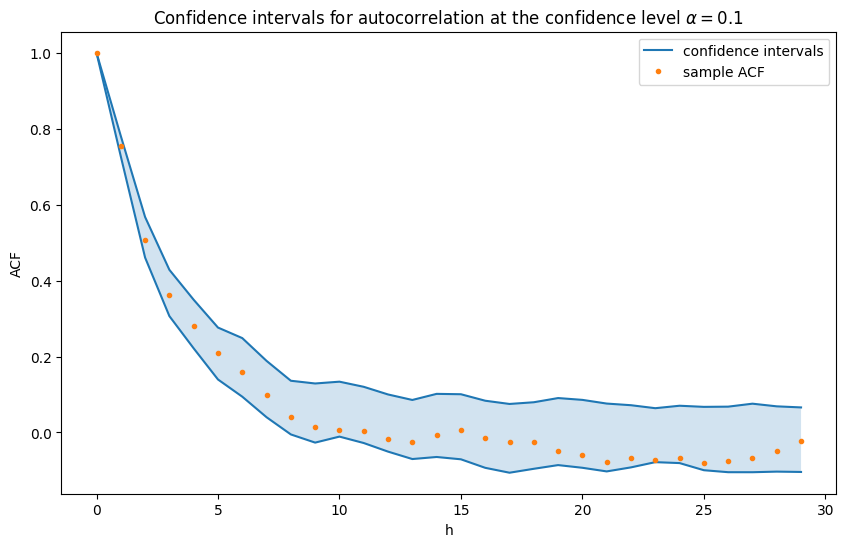

In [133]:
plt.plot(h, ACV05, color='C0')
plt.plot(h, ACV95, color='C0', label='confidence intervals')
plt.fill_between(h, ACV05, ACV95, alpha=0.2)
plt.plot(h, ACF_X3, '.', color='C1', label='sample ACF')
plt.ylabel('ACF')
plt.xlabel('h')
plt.title('Confidence intervals for autocorrelation at the confidence level $\\alpha = 0.1$')
plt.legend()
plt.savefig('zdjecia/ACF_przedzialy.png', dpi=150)
plt.show()

In [115]:
sum((ACF_X3 >= ACV05) & (ACF_X3 <= ACV95))/len(h)

1.0

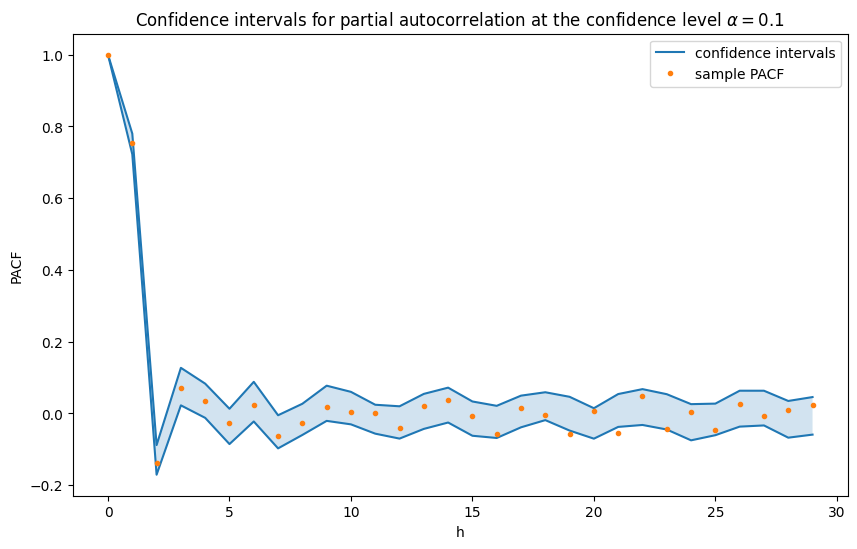

In [134]:
plt.plot(h, PACF05, color='C0')
plt.plot(h, PACF95, color='C0', label='confidence intervals')
plt.fill_between(h, PACF05, PACF95, alpha=0.2)
plt.plot(h, PACF_X3, '.', color='C1', label='sample PACF')
plt.ylabel('PACF')
plt.xlabel('h')
plt.title('Confidence intervals for partial autocorrelation at the confidence level $\\alpha = 0.1$')
plt.legend()
plt.savefig('zdjecia/PACF_przedzialy.png', dpi=150)
plt.show()

In [114]:
sum((PACF_X3 >= PACF05) & (PACF_X3 <= PACF95))/len(h)

0.9333333333333333

In [87]:
def quantile_lines(quantiles, phi, theta, sigma2, n, N=100):
    traj = np.array([arma_generate_sample(phi, theta, n, np.sqrt(sigma2)) for _ in range(N)])
    result = np.zeros((len(quantiles), n))
    for i in range(len(quantiles)):
        result[i] = np.array([np.quantile(traj[:, j], quantiles[i]) for j in range(n)])
    return result

In [88]:
quantiles = np.array([0.05, 0.25, 0.95, 0.75])
lines = quantile_lines(quantiles, phi_to_intervals, theta_to_intervals, sigma2, len(X3), 2000)

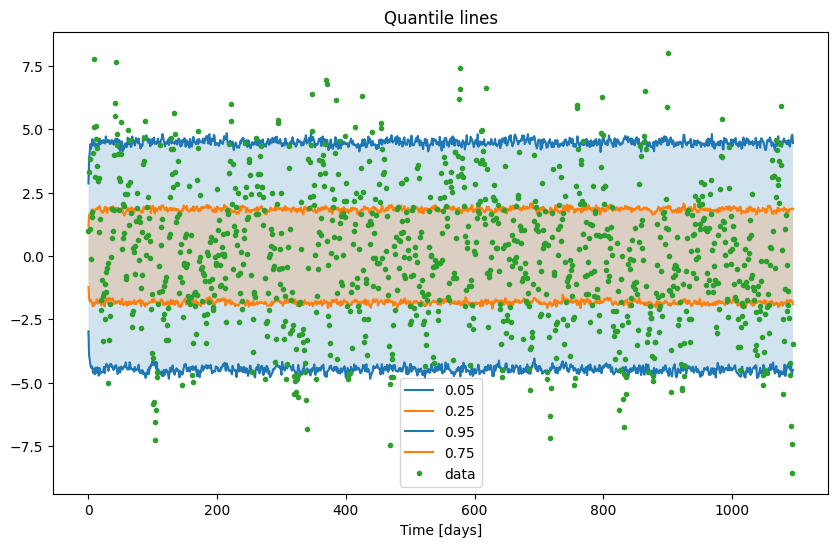

In [135]:
for i in range(len(lines)):
    plt.plot(lines[i], label=f'{quantiles[i]}', color=f'C{i%2}')
plt.fill_between(np.arange(len(lines[0])), lines[0], lines[2], alpha=0.2)
plt.fill_between(np.arange(len(lines[0])), lines[1], lines[3], alpha=0.2)
plt.plot(X3, '.', label='data', color='C2')
plt.title('Quantile lines')
plt.xlabel('Time [days]')
plt.legend()
plt.savefig('zdjecia/linie_kwantylowe.png', dpi=150)
plt.show()

In [124]:
sum((lines[0] <= X3) & (X3 <= lines[2]))/len(X3)

0.8914233576642335

In [126]:
sum((lines[1] <= X3) & (X3 <= lines[3]))/len(X3)

0.5009124087591241

#### Prediction

In [91]:
def prediction_confidence_intervals(model, n, alpha=0.05):
    X_pred = model.forecasts[0][:n]
    sigma2 = model.params[-1]

    left = X_pred - stats.norm.ppf(1-alpha/2) * np.sqrt(sigma2)
    right = X_pred + stats.norm.ppf(1-alpha/2) * np.sqrt(sigma2)
    return left, right

In [92]:
left, right = prediction_confidence_intervals(arma_model_fit, len(t_test))

In [93]:
222/len(left)

0.6082191780821918

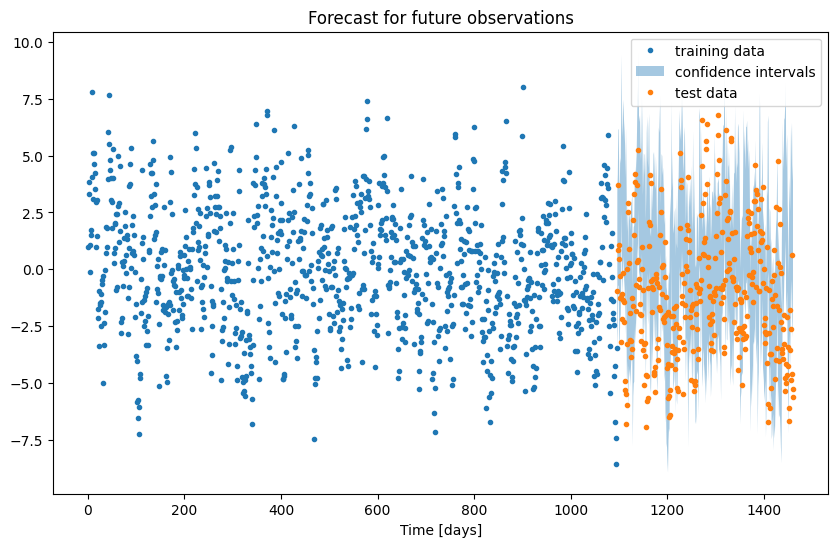

In [136]:
plt.plot(t, X3, '.', label='training data')
plt.fill_between(t_test, left, right, alpha=0.4, label='confidence intervals')
plt.plot(t_test, X_test, '.', label='test data')
plt.legend()
plt.title('Forecast for future observations')
plt.xlabel('Time [days]')
plt.savefig('zdjecia/prognoza_przedzialy.png', dpi=150)
plt.show()

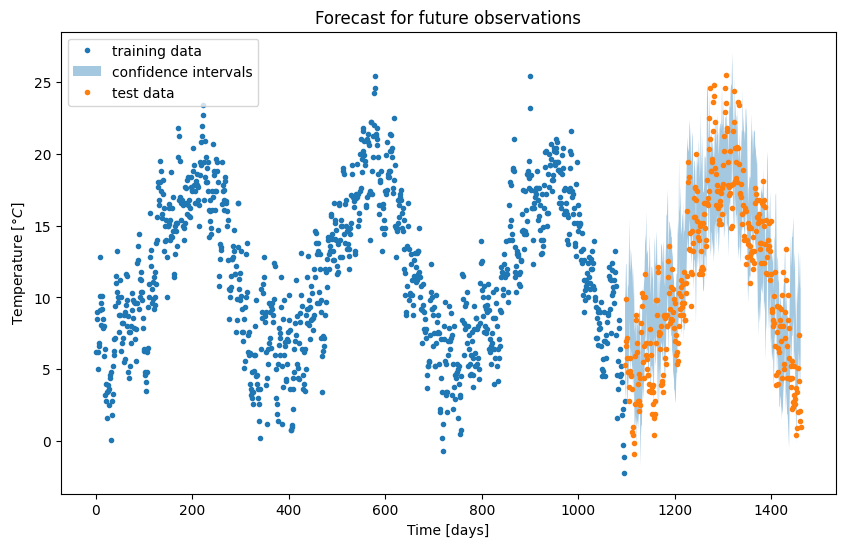

In [137]:
plt.plot(t, X, '.', label='training data')
plt.fill_between(t_test, left + m(t_test, b1, b0) + s(t_test, b1_, b2_, b3_), right + m(t_test, b1, b0) + s(t_test, b1_, b2_, b3_), alpha=0.4, label='confidence intervals')
plt.plot(t_test, X_test_raw, '.', label='test data')
plt.legend()
plt.title('Forecast for future observations')
plt.xlabel('Time [days]')
plt.ylabel('Temperature [$\degree C$]')
plt.savefig('zdjecia/prognoza_przedzialy2.png', dpi=150)
plt.show()

### Residuals

In [96]:
residua = arma_model_fit.resid

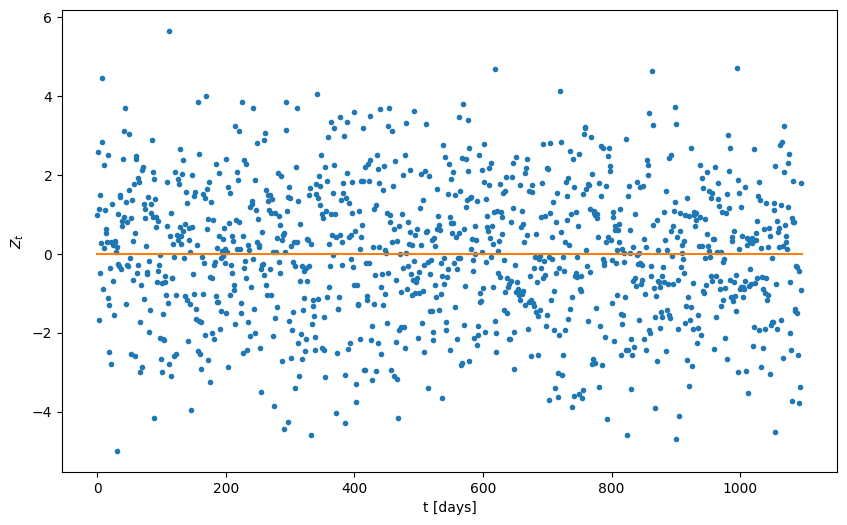

In [138]:
plt.plot(residua, '.')
plt.plot([0, len(residua)], [0, 0])
plt.xlabel('t [days]')
plt.ylabel('$Z_t$')
plt.savefig('zdjecia/residua.png', dpi=150)
plt.show()

t-test

In [98]:
stats.ttest_1samp(residua, 0)

TtestResult(statistic=-0.009976989470834995, pvalue=0.9920414635460801, df=1095)

Tests for variance

In [99]:
k = int(len(residua)/2)
stats.levene(residua[:k], residua[k:])

LeveneResult(statistic=0.561411767789122, pvalue=0.4538530551987019)

In [100]:
het_arch(residua, ddof=p+q)

(11.373717050485416,
 0.3291525781679826,
 1.147376526358736,
 0.32315834209320365)

#### Checking the independence of residuals

ACF and PACF

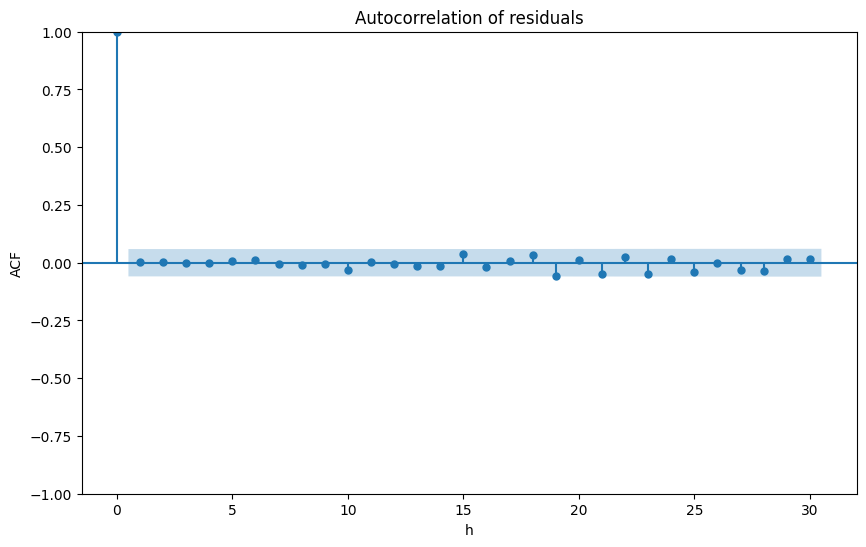

In [139]:
plot_acf(residua, lags=30)
plt.xlabel('h')
plt.ylabel('ACF')
plt.title('Autocorrelation of residuals')
plt.savefig('zdjecia/residua_ACF.png', dpi=150)
plt.show()

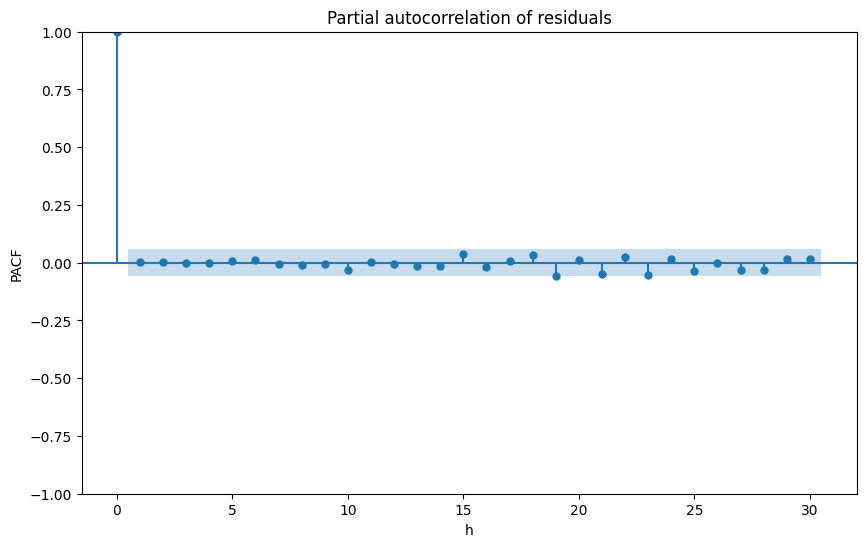

In [140]:
plot_pacf(residua, lags=30)
plt.title('Partial autocorrelation of residuals')
plt.ylabel('PACF')
plt.xlabel('h')
plt.savefig('zdjecia/residua_PACF.png', dpi=150)
plt.show()

Ljung-Box Test

In [103]:
acorr_ljungbox(residua)

,lb_stat,lb_pvalue
1,0.002514,0.960015
2,0.003961,0.998022
3,0.006745,0.999853
4,0.008661,0.999991
5,0.068813,0.999936
6,0.192002,0.999863
7,0.210112,0.999970
8,0.286599,0.999984
9,0.311311,0.999996
10,1.380784,0.999261


#### checking whether the data has a normal distribution

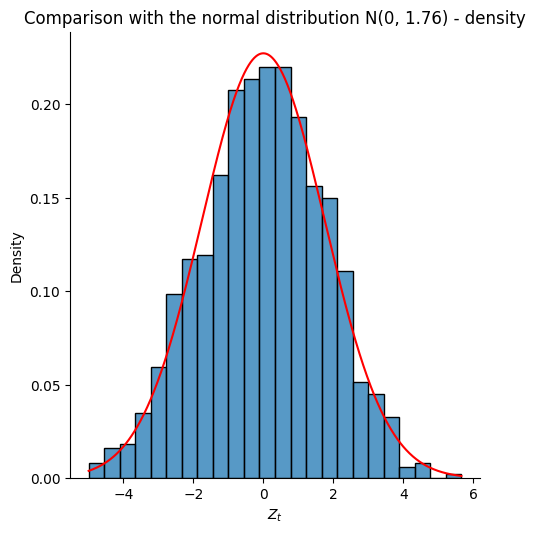

In [141]:
sb.displot(residua, stat='density')
x = np.linspace(min(residua), max(residua), 1000)
plt.plot(x, stats.norm.pdf(x, np.mean(residua), np.std(residua)), 'r')
plt.xlabel('$Z_t$')
plt.title('Comparison with the normal distribution N(0, 1.76) - density')
plt.savefig('zdjecia/gestosc.png', dpi=150)
plt.show()

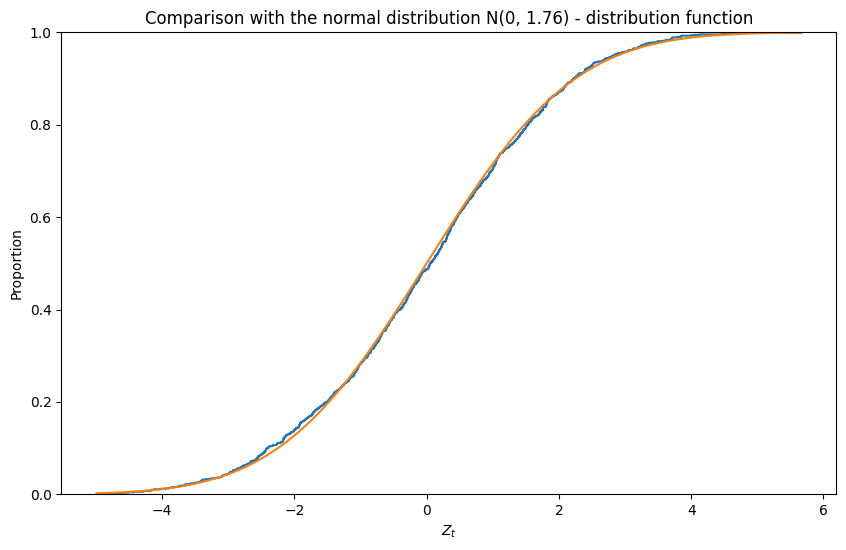

In [142]:
sb.ecdfplot(residua)
plt.plot(x, stats.norm.cdf(x, np.mean(residua), np.std(residua)))
plt.xlabel('$Z_t$')
plt.title('Comparison with the normal distribution N(0, 1.76) - distribution function')
plt.savefig('zdjecia/dystrybuanta.png', dpi=150)
plt.show()

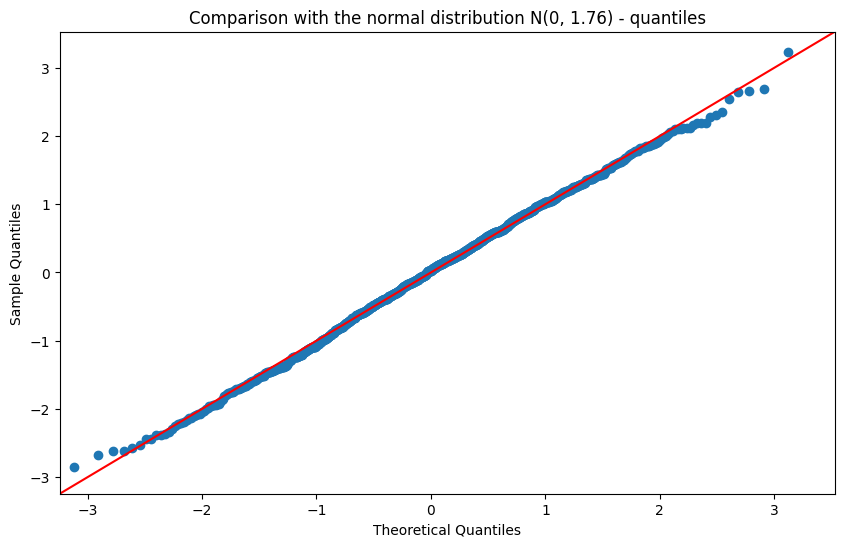

In [143]:
qqplot(residua, stats.norm, line='45', fit=True)
plt.title('Comparison with the normal distribution N(0, 1.76) - quantiles')
plt.savefig('zdjecia/qqplot.png', dpi=150)
plt.show()

In [107]:
stats.shapiro(residua)

ShapiroResult(statistic=0.9980538229597822, pvalue=0.23670036610854667)